In [1]:
# Progress bars, requires ipywidgets
from tqdm.notebook import tqdm

In [3]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('averaged_perceptron_tagger')
import itertools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report

In [4]:
import re

In [5]:
import os

In [6]:
import datetime

In [7]:
# data = "amazon_reviews/dataset/Video_Games_5.json.gz"
data = "dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [8]:
X = df.reviewText[df.reviewText.notnull()].values
y = df.overall[df.reviewText.notnull()].values

In [9]:
sentiment_is_positive = y > 3

In [10]:
sentiment_categories, counts = np.unique(sentiment_is_positive, return_counts=True)
dict(zip(sentiment_categories, counts))

{False: 236886, True: 890786}

In [11]:
dict(zip(sentiment_categories, counts/len(sentiment_is_positive)))

{False: 0.2100664022871899, True: 0.7899335977128101}

# Definitions for vectorizer class

## Preprocessing Function

In [12]:
slang_repl = {
    "gr8t*": "great"
}
# TODO: add slang/abbreviations

In [13]:
emoticon_repl = {
    # positive emoticons
    ":-?d+": " good ", # :D, :-D, :DD, ecc. in lower case
    ":-?\)+": " good ", # :-), :), :-)), :)), ecc
    ";-?\)+": " good ", # ;). ;)). ;-), ecc.
    "\(+-?:": " good ", # (:, (-:, ecc.
    # negative emoticons
    ":/": " bad ", # :/
    re.escape(":\\"): " bad ", # :\
    "\)-?:": "bad",  # ):, )):, )-:, ecc.
    ":-?\(+": " bad ", # :(, :-(, :((, ecc.
    "d+-?:" : "bad" # D:, D-:, ecc. in lower case
    # ":-?S+": " bad " # :S, :-S, :SS
}
# TODO: add other emoticons?

Funzione per controllare se effettivamente questi termini slang/emoticons sono presenti in qualche recensione (utilizzata per scegliere abbreviazioni/emoticons):

In [14]:
# Check if re is present in some review
def bar(regex, stop = 1):
    j = 0
    for i in tqdm(range(len(X))):
        if re.search(regex, X[i].lower()):
            j += 1
            print(i)
            print(re.findall(regex, X[i].lower()))
            print(X[i]+"\n")
            if j == stop:
                break

In [15]:
bar(":-?d+")

3248
[':d']
Great!!! Love to use this to change my voice to a squeaker :D



Funzione per controllare se effettivamente un emoticon/termine slang corrisponde al sentimento atteso:

In [16]:
# Check if re is present in some review
def foo(regex):
    pos = 0
    neg = 0
    for i in tqdm(range(len(X))):
        if re.search(regex, X[i].lower()):
            if sentiment_is_positive[i]:
                pos += 1
            else:
                neg += 1
    tot = pos + neg
    print("Positive reviews containing {} : {}, {}%\nNegative reviews containing {} : {}, {}%".format(regex, pos, pos/tot, regex, neg, neg/tot))

E.g., ci aspetteremmo che ":)" compare in più recensioni negative che positive, quindi tradurlo in "good" ha senso.

In [17]:
for k in emoticon_repl:
    foo(k)


Positive reviews containing :-?d+ : 556, 0.9553264604810997%
Negative reviews containing :-?d+ : 26, 0.044673539518900345%



Positive reviews containing :-?\)+ : 8712, 0.9374798235230819%
Negative reviews containing :-?\)+ : 581, 0.06252017647691811%




Positive reviews containing ;-?\)+ : 1077, 0.8952618453865336%
Negative reviews containing ;-?\)+ : 126, 0.10473815461346633%



Positive reviews containing \(+-?: : 265, 0.9397163120567376%
Negative reviews containing \(+-?: : 17, 0.06028368794326241%



Positive reviews containing :/ : 4232, 0.8121281903665324%
Negative reviews containing :/ : 979, 0.18787180963346767%



Positive reviews containing :\\ : 6, 0.3157894736842105%
Negative reviews containing :\\ : 13, 0.6842105263157895%



Positive reviews containing \)-?: : 641, 0.7436194895591647%
Negative reviews containing \)-?: : 221, 0.25638051044083526%



Positive reviews containing :-?\(+ : 904, 0.3312568706485892%
Negative reviews containing :-?\(+ : 1825, 0.6687431293514108%



Positive reviews containing d+-?: : 2328, 0.6920332936979786%
Negative reviews containing d+-?: : 1036, 0.3079667063020214%


Un po' strano: ci sono più recensioni positive che contengono ):, )-: e simili rispetto a recensioni negative.

In [18]:
foo("\)-?:")


Positive reviews containing \)-?: : 641, 0.7436194895591647%
Negative reviews containing \)-?: : 221, 0.25638051044083526%


Forse meglio lasciarlo perdere:

In [19]:
del emoticon_repl["\)-?:"]

idem per :/ :

In [20]:
foo(":/")


Positive reviews containing :/ : 4232, 0.8121281903665324%
Negative reviews containing :/ : 979, 0.18787180963346767%


In [21]:
del emoticon_repl[":/"]

Idem per D: :

In [22]:
foo("d+-?:")


Positive reviews containing d+-?: : 2328, 0.6920332936979786%
Negative reviews containing d+-?: : 1036, 0.3079667063020214%


In [23]:
del emoticon_repl["d+-?:"]

In [24]:
foo("gr8t*")


Positive reviews containing gr8t* : 117, 0.9212598425196851%
Negative reviews containing gr8t* : 10, 0.07874015748031496%


Forme contratte:

In [25]:
contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not",
    r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not",
    r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not",
    r"n\'": " not",
    r"\'s": " is"
}

Funzione di preprocessing da passare a TfidfVectorizer:

In [26]:
def preprocess(sent):
    
    sent = sent.lower()
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    for k in slang_repl:
        sent = re.sub(k, slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[.,;:;!?%"\'\`\(\)]+', '', sent) # remove symbols
    sent = re.sub("\S*\d+\S*\s", '', sent) # remove words containing numbers. Not sure if necessary/makes sense
    
    return sent

In [27]:
# stop = 1
# j = 0
# for i in tqdm(range(len(X))):
#     sent = X[i].lower()
#     if re.search(r"n\'t", sent) and re.search(":-?\(+", sent):
#         j += 1
#         print(i)
#         print(re.findall(r"n\'t", X[i].lower()))
#         print(X[i]+"\n")
#         if j == stop:
#             break

In [28]:
# for i in tqdm(range(len(X))):
#     sent = X[i].lower()
#     if re.search(":-?\)+", sent) and re.search("gr8t*", sent):
#         print(i)
#         print(re.findall(":-?\)+", X[i].lower()))
#         print(X[i]+"\n")

Esempi:

In [29]:
X[27]

"crystals fell off as nothing :( that's why I really didn't like it but as soon as I saw it I liked it but the stones"

In [30]:
preprocess(X[27])

'crystals fell off as nothing  bad  that is why i really did not like it but as soon as i saw it i liked it but the stones'

In [31]:
X[702597]

'Gr8t product, Looks stylish in my car :-)'

In [32]:
preprocess(X[702597])

'great product looks stylish in my car  good '

## Stop-words list

In [33]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")
stopws = stopws[:-36] # remove contracted words (already dealt with)
stopws.remove("not")
stopws.remove("don")
stopws.remove("don't")
stopws.append('\'s')

Lista di stopwords da passare al TfidfVectorizer (processata come il resto del testo):

In [34]:
prep_stopws = [preprocess(el) for el in stopws]

## Stemming

In [35]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

Classe TfidfVectorizer + Stemming. (Volendo possiamo mettere nltk, per ora per velocità ho messo questa).

In [37]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, sentiment_is_positive, test_size=0.33, random_state=42)

## NB Classifier

In [39]:
stemmed_tfidf_ngrams_vect = StemmedTfidfVectorizer(min_df=5, max_features = 50000,
                                                   ngram_range=(1,2), preprocessor=preprocess,
                                                  stop_words=prep_stopws)

In [40]:
before = datetime.datetime.now()

X_train_vect = stemmed_tfidf_ngrams_vect.fit_transform(X_train)

after = datetime.datetime.now()
(after-before).seconds

221

In [42]:
before = datetime.datetime.now()

X_test_vect = stemmed_tfidf_ngrams_vect.transform(X_test)

after = datetime.datetime.now()
(after-before).seconds

86

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

In [45]:
X_train_vect.shape

(755540, 50000)

In [46]:
clf = MultinomialNB()
clf.fit(X_train_vect, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
def print_top_features(feature_names, clf, n = 10):
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(feature_names[j] for j in top_pos))

In [48]:
fnames = stemmed_tfidf_ngrams_vect.get_feature_names()
print_top_features(fnames, clf, 100)

Most discriminative features:
 great, good, case, love, phone, work, not, product, nice, perfect, excel, fit, like, use, well, protect, charg, screen, one, look, price, works great, easi, thank, qualiti, protector, great product, time, would, realli, get, iphon, recommend, need, charger, screen protector, buy, batteri, awesom, color, bought, cabl, feel, expect, best, cover, littl, fast, ok, purchas, drop, great cas, much, instal, item, make, still, good product, got, hold, also, put, ive, describ, back, far, devic, want, happi, high, im, works wel, review, pretti, better, go, problem, keep, new, take, order, thing, come, made, even, love cas, excelent, durabl, seem, fine, exact, job, fits perfect, button, issu, without, quick, receiv, galaxi, good qual


Train Accuracy       0.88936
Test Accuracy        0.88382
Test Precision       0.89531
Test Recall          0.96584
F1                   0.92924
F2                   0.95086
P/R AUC              0.97730


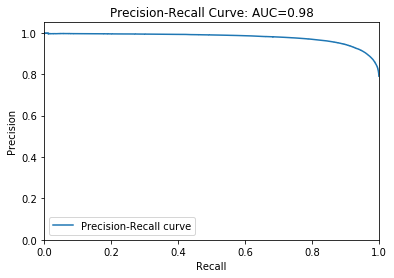

In [49]:
train_score = clf.score(X_train_vect, y_train) # Train Accuracy
test_score = clf.score(X_test_vect, y_test)    # Test Accuracy

predictions = clf.predict(X_test_vect)

prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

cm

proba = clf.predict_proba(X_test_vect)

precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

auc_score = auc(recall, precision)

scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## Using the "Summary" column

In [50]:
df["summary"].head()

0    Can't stop won't stop looking at it
1                                      1
2                               Its okay
3                                   CASE
4                                  Cute!
Name: summary, dtype: object

Prima abbiamo considerato solo le recensioni tali che `df.reviewText.notnull()`

Se ora vogliamo considerare anche il summary:

In [51]:
sum(df.reviewText.notnull() & df.summary.isnull())

466

Riempio i valori mancanti di `summary` con la recensione:

In [52]:
df["summary"] = df['summary'].fillna(df['reviewText'])

In [53]:
sum(df.reviewText.notnull() & df.summary.isnull())

0

In [54]:
X2 = df.summary[df.reviewText.notnull()].values

In [55]:
X2

array(["Can't stop won't stop looking at it", '1', 'Its okay', ...,
       'Get more out of your smartphone .......',
       'Join the VR fun train!', 'Five Stars'], dtype=object)

## Train-test split

In [56]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, sentiment_is_positive, test_size=0.33, random_state=42)

(la divisione train/test è uguale a prima)

In [57]:
all(y_train == y2_train)

True

In [58]:
all(y_test == y2_test)

True

## NB Classifier

In [59]:
stemmed_tfidf_ngrams_vect2 = StemmedTfidfVectorizer(min_df=5, max_features = 50000,
                                                   ngram_range=(1,2), preprocessor=preprocess,
                                                  stop_words=prep_stopws)

In [60]:
before = datetime.datetime.now()

X2_train_vect = stemmed_tfidf_ngrams_vect2.fit_transform(X2_train)

after = datetime.datetime.now()
(after-before).seconds

30

In [62]:
before = datetime.datetime.now()

X2_test_vect = stemmed_tfidf_ngrams_vect2.transform(X2_test)

after = datetime.datetime.now()
(after-before).seconds

14

In [64]:
X2_train_vect.shape

(755540, 37137)

In [65]:
clf2 = MultinomialNB()
clf2.fit(X2_train_vect, y2_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
fnames2 = stemmed_tfidf_ngrams_vect2.get_feature_names()
print_top_features(fnames2, clf2, 100)

Most discriminative features:
 five star, five, star, great, four, four star, case, love, good, nice, work, perfect, product, phone, great cas, excel, awesom, great product, protect, fit, price, best, like, works great, qualiti, buy, screen, well, protector, look, charger, not, easi, screen protector, iphon, nice cas, use, recommend, good product, good cas, charg, love cas, one, cabl, cute, pretti, happi, batteri, cover, great pric, amaz, realli, need, valu, worth, phone cas, far, high, better, works wel, great phon, job, get, sturdi, must, beauti, color, expect, great protect, good qual, perfect fit, durabl, fast, littl, instal, purchas, galaxi, power, great buy, solid, item, slim, ever, money, super, deal, cool, feel, samsung, would, fantast, ok, otterbox, note, design, fine, best cas, highly recommend, great charg, mount


In [67]:
train_score2 = clf2.score(X2_train_vect, y2_train) # Train Accuracy
test_score2 = clf2.score(X2_test_vect, y2_test)    # Test Accuracy

predictions2 = clf2.predict(X2_test_vect)

prec2 = precision_score(y2_test, predictions2) # Precision
rec2 = recall_score(y2_test, predictions2) # Recall
f12 = f1_score(y2_test, predictions2) # F1
f22 = fbeta_score(y2_test, predictions2, 2) # F2
cm2 = confusion_matrix(y2_test, predictions2)

cm2

array([[ 56737,  21487],
       [ 11730, 282178]], dtype=int64)

In [68]:
proba2 = clf2.predict_proba(X2_test_vect)

precision2, recall2, pr_thresholds2 = precision_recall_curve(y2_test, proba2[:,1])

auc_score2 = auc(recall2, precision2)

scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

scores2 = [train_score2, test_score2, prec2, rec2, f12, f22, auc_score2]

print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores2))))

Train Accuracy       0.91680
Test Accuracy        0.91074
Test Precision       0.92924
Test Recall          0.96009
F1                   0.94441
F2                   0.95376
P/R AUC              0.98438


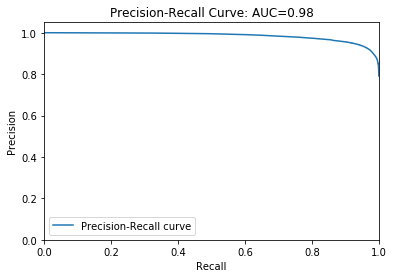

In [69]:
plt.plot(recall2, precision2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## Combination of review and summary

In [70]:
from sklearn.metrics import accuracy_score

In [71]:
def score(pred, real):
    acc = accuracy_score(real, pred)
    prec = precision_score(real, pred) # Precision
    rec = recall_score(real, pred) # Recall
    f1 = f1_score(real, pred) # F1
    f2 = fbeta_score(real, pred, 2) # F2
    
    scores_strings = ["Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2"]

    scores = [acc, prec, rec, f1, f2]
    print(("{:20s} {:.5f}\n"*5)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

In [72]:
# predictions : predictions for classifier with reviews only
# predictions2 : predictions for classifier with summary only
predictions_and = predictions & predictions2
predictions_or = predictions | predictions2

In [73]:
score(predictions_and, y_test)

Test Accuracy        0.91505
Test Precision       0.95698
Test Recall          0.93444
F1                   0.94558
F2                   0.93886


In [74]:
score(predictions_or, y_test)

Test Accuracy        0.87951
Test Precision       0.87315
Test Recall          0.99149
F1                   0.92856
F2                   0.96532


Only Reviews Recap:

- Test Accuracy        0.88360
- Test Precision       0.89507
- Test Recall          0.96586
- F1                   0.92912
- F2                   0.95082

Only Summaries Recap:

- Test Accuracy        0.91074
- Test Precision       0.92925
- Test Recall          0.96009
- F1                   0.94442
- F2                   0.95376